## Ideas

* Embeddings are weighted by the cost of treatment
* Look at how often each treatment occurs for fraudelent receipts

## Features

* number of treatments
* clients buckets (cluster client types in advance)

In [1]:
import pandas as pd
import numpy as np

In [2]:
data1 = pd.read_csv('data/arzta_daten_anonym1.csv', sep=';')
data2 = pd.read_csv('data/arzta_daten_anonym2.csv', sep=';')
data3 = pd.read_csv('data/arzta_daten_anonym3.csv', sep=';')
data4 = pd.read_csv('data/arzta_daten_anonym4.csv', sep=';')

data = pd.concat([data1, data2, data3, data4])

In [3]:
%%time

columns_comma = ['RECHNUNGSBETRAG', 'FAKTOR', 'BETRAG', 'ALTER', 'KORREKTUR']

data[columns_comma] = data[columns_comma].apply(lambda x: x.str.replace(',', '.'))

for column in columns_comma:
    data[column] = pd.to_numeric(data[column], downcast='float')

CPU times: user 15.5 s, sys: 1.54 s, total: 17 s
Wall time: 17.8 s


In [4]:
data.head()

,ID,KORREKTUR,RECHNUNGSBETRAG,ALTER,GESCHLECHT,VERSICHERUNG,FACHRICHTUNG,NUMMER,NUMMER_KAT,TYP,ANZAHL,FAKTOR,BETRAG,ART,LEISTUNG
0,ID_1,0.0,330.970001,53.570385,0,1,1,A_178,AA_10,0.0,2,2.30,24.400000,NaN,C_1
1,ID_2,0.0,455.200012,83.382721,1,1,1,A_765,AA_13,0.0,1,1.15,2.010000,NaN,C_6
2,ID_3,0.0,199.529999,69.567513,1,1,1,A_1978,AA_2,0.0,1,2.30,21.450001,NaN,C_1
3,ID_4,0.0,142.850006,69.556328,1,1,1,A_1257,AA_3,0.0,3,2.30,32.160000,NaN,C_1
4,ID_5,0.0,168.869995,18.873434,0,1,1,A_737,AA_13,0.0,1,1.15,3.350000,NaN,C_6


In [5]:
cols_mapping = {
    'ID': 'id',
    'KORREKTUR': 'adj',
    'RECHNUNGSBETRAG': 'amount',
    'ALTER': 'age',
    'GESCHLECHT': 'sex',
    'VERSICHERUNG': 'ins_type',
    'FACHRICHTUNG': 'speciality',  # why only 0/1 ?
    'NUMMER': 'treatment',
    'NUMMER_KAT': 'treatment_type',
    'TYP': 'billing_type',
    'ANZAHL': 'num_treatments',
    'FAKTOR': 'factor',
    'BETRAG': 'cost',
    'ART': 'cost_type',
    'LEISTUNG': 'ben_type'
}

In [6]:
data = data.rename(columns=cols_mapping)

In [7]:
data.head()

,id,adj,amount,age,sex,ins_type,speciality,treatment,treatment_type,billing_type,num_treatments,factor,cost,cost_type,ben_type
0,ID_1,0.0,330.970001,53.570385,0,1,1,A_178,AA_10,0.0,2,2.30,24.400000,NaN,C_1
1,ID_2,0.0,455.200012,83.382721,1,1,1,A_765,AA_13,0.0,1,1.15,2.010000,NaN,C_6
2,ID_3,0.0,199.529999,69.567513,1,1,1,A_1978,AA_2,0.0,1,2.30,21.450001,NaN,C_1
3,ID_4,0.0,142.850006,69.556328,1,1,1,A_1257,AA_3,0.0,3,2.30,32.160000,NaN,C_1
4,ID_5,0.0,168.869995,18.873434,0,1,1,A_737,AA_13,0.0,1,1.15,3.350000,NaN,C_6


In [8]:
data['target'] = data['adj'].astype(bool).astype(int)

data = data.drop(columns=['adj'])

In [9]:
# let's look at some fraudelent receipt

data[data['id'] == 'ID_128240']

,id,amount,age,sex,ins_type,speciality,treatment,treatment_type,billing_type,num_treatments,factor,cost,cost_type,ben_type,target
190513,ID_128240,669.98999,78.153198,1,1,1,A_2043,AA_7,0.0,1,3.5,123.419998,NaN,C_1,1
310398,ID_128240,669.98999,78.153198,1,1,1,A_545,AA_3,0.0,1,1.8,4.200000,NaN,C_1,1
726261,ID_128240,669.98999,78.153198,1,1,1,A_2030,AA_7,0.0,1,2.3,26.139999,NaN,C_1,1
920372,ID_128240,669.98999,78.153198,1,1,1,A_2053,AA_7,0.0,1,2.3,93.839996,NaN,C_1,1
340873,ID_128240,669.98999,78.153198,1,1,1,A_2052,AA_7,0.0,1,2.3,73.730003,NaN,C_1,1
859812,ID_128240,669.98999,78.153198,1,1,1,A_1978,AA_2,0.0,1,2.3,21.450001,NaN,C_1,1
289596,ID_128240,669.98999,78.153198,1,1,1,A_2001,AA_2,0.0,1,2.3,17.430000,NaN,C_1,1
603587,ID_128240,669.98999,78.153198,1,1,1,A_2059,AA_7,0.0,1,2.3,30.830000,NaN,C_9,1
810814,ID_128240,669.98999,78.153198,1,1,1,NaN,AA_1,NaN,1,0.0,0.700000,B_2,C_2,1
98927,ID_128240,669.98999,78.153198,1,1,1,A_2047,AA_7,0.0,1,2.3,21.180000,NaN,C_1,1


In [10]:
# check if we constructed target column right

(data.groupby('id')['target'].nunique() == 1).mean()

1.0

In [11]:
data['treatment'] = data['treatment'].fillna(value='<UNK>')
data['treatment_type'] = data['treatment_type'].fillna(value='<UNK>')

In [12]:
data.to_csv('data/data.csv', index=False)

In [15]:
data[data['treatment'] == '<UNK>']

,id,amount,age,sex,ins_type,speciality,treatment,treatment_type,billing_type,num_treatments,factor,cost,cost_type,ben_type,target
7,ID_8,41.770000,66.947693,1,1,1,<UNK>,AA_1,NaN,1,0.0,0.700000,B_2,C_2,0
12,ID_13,82.980003,43.645576,1,1,1,<UNK>,AA_1,NaN,1,0.0,5.500000,B_2,C_2,0
23,ID_24,414.480011,41.646633,0,1,1,<UNK>,AA_1,NaN,1,0.0,4.750000,B_2,C_2,0
31,ID_32,124.019997,62.440262,1,1,1,<UNK>,AA_1,NaN,1,0.0,5.370000,B_2,C_2,0
35,ID_36,52.349998,66.161354,1,1,1,<UNK>,AA_1,NaN,1,0.0,6.100000,B_2,C_2,0
47,ID_48,17.330000,36.631660,1,1,1,<UNK>,AA_1,NaN,1,0.0,3.920000,B_2,C_2,0
51,ID_52,311.570007,49.734108,1,1,1,<UNK>,AA_1,NaN,1,0.0,1.500000,B_3,C_21,0
53,ID_52,311.570007,49.734108,1,1,1,<UNK>,AA_1,NaN,1,0.0,0.840000,B_3,C_21,0
57,ID_57,17.330000,64.800438,0,1,1,<UNK>,AA_1,NaN,1,0.0,3.920000,B_2,C_2,0
76,ID_76,22.660000,63.319801,1,1,1,<UNK>,AA_1,NaN,1,0.0,2.560000,B_2,C_2,0


In [20]:
ex = data[data['id'] == 'ID_128240']

In [48]:
' '.join(ex['treatment'].tolist())

'A_2043 A_545 A_2030 A_2053 A_2052 A_1978 A_2001 A_2059 UNK_TREATMENT A_2047 A_2044 A_2052'

## Graphs

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline 

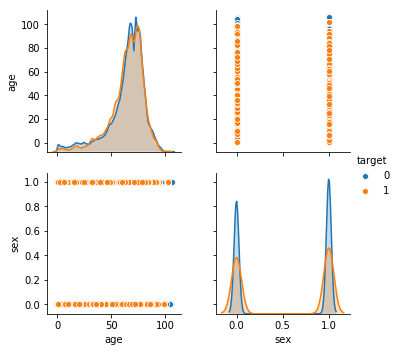

In [27]:
sns.pairplot(data,
             x_vars=['age', 'sex'],
             y_vars=['age', 'sex'],
             hue='target')

<Figure size 432x288 with 0 Axes>

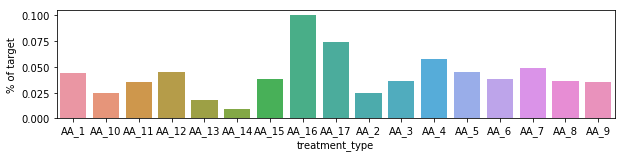

In [32]:
col = 'treatment_type'

plt.figure()
fig, ax = plt.subplots(figsize=(10,2))

sub_data = data[[col, 'target']].groupby([col], as_index=False).mean()
sns.barplot(ax=ax, x=col, y='target', data=sub_data, order=sub_data[col])

plt.ylabel('% of target', fontsize=10)
plt.xlabel(col, fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data/data.csv')

In [5]:
data

,id,amount,age,sex,ins_type,speciality,treatment,treatment_type,billing_type,num_treatments,factor,cost,cost_type,ben_type,target
0,ID_1,330.97,53.570385,0,1,1,A_178,AA_10,0.0,2,2.30,24.40,NaN,C_1,0
1,ID_2,455.20,83.382720,1,1,1,A_765,AA_13,0.0,1,1.15,2.01,NaN,C_6,0
2,ID_3,199.53,69.567510,1,1,1,A_1978,AA_2,0.0,1,2.30,21.45,NaN,C_1,0
3,ID_4,142.85,69.556330,1,1,1,A_1257,AA_3,0.0,3,2.30,32.16,NaN,C_1,0
4,ID_5,168.87,18.873434,0,1,1,A_737,AA_13,0.0,1,1.15,3.35,NaN,C_6,0
5,ID_6,113.66,77.866140,0,1,1,A_719,AA_2,0.0,1,2.30,40.23,NaN,C_1,0
6,ID_7,2775.21,77.866140,0,1,1,A_1874,AA_15,0.0,1,2.20,128.23,NaN,C_5,0
7,ID_8,41.77,66.947690,1,1,1,<UNK>,AA_1,NaN,1,0.00,0.70,B_2,C_2,0
8,ID_9,70.63,30.238573,0,1,1,A_1122,AA_13,0.0,1,1.15,16.76,NaN,C_6,0
9,ID_10,104.90,52.904440,0,1,1,A_877,AA_13,0.0,1,1.15,16.76,NaN,C_6,0
